# Testing Algorithms for Paper

## Name: Victor Agaba

## Date: 2024-04-11

***

In [8]:
# %matplotlib widget
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as rm
from package import optimizer as opt
from package import plots
import numpy as np
from obspy.taup import TauPyModel
np.set_printoptions(precision=4, suppress=True)

***
#### Synthetic Parameters
***

In [9]:
seed = np.random.randint(0, 2025)
# seed = 25
np.random.seed(seed)
print(f'Seed: {seed}')
# np.random.seed(1513)
# np.random.seed(555)

# # BUG plot_iterates_2D (off by 1)
# np.random.seed(560)

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)



# t = np.array([ 0.11727534, -0.38461938,  0.91559512])
# t = fn.unit_vec(t)
# p = np.array([-0.31832113,  0.85875371,  0.4015143 ])
# p = fn.unit_vec(p)



# ### NOTE FOR COMPARISON ###
t, p = fn.i_hat, fn.k_hat
# t, p = fn.unit_vec(fn.i_hat + fn.j_hat), fn.unit_vec(fn.j_hat - fn.i_hat)
# t, p = fn.i_hat, fn.j_hat

Seed: 703


Original params:  [  0.  45. -90.]


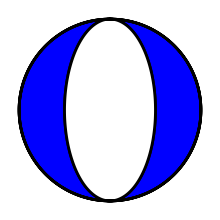

Takeoff angles: [45.74277419944782, 49.94361025435123]


In [10]:
#################################################################
# USE OBSPY TO PRODUCE BEACHBALLS FROM DIFFERENT INPUT PARAMETERS
# VERIFY CONSISTENCY FOR OUR vs OBSPY FUNCTIONS
#################################################################


# get true params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)


# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
# model = TauPyModel(model='iasp...')
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
p_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P'])
s_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['S'])
takeoff_angles = [p_arrivals[0].takeoff_angle, s_arrivals[0].takeoff_angle]
print(f"Takeoff angles: {takeoff_angles}")


true_hidden = fn.tp2hidden(t, p, azimuth, in_deg=True)


#############################################
# EXTRACT VELOCITIES FROM LOOKUP TABLE
#############################################
# look for them in TauPy, may not work
# use linear interpolation from Suzan's table
#############################################
velocities = np.array([5.8000, 3.4600])

***
#### Hybrid Inversion
***

In [11]:
importlib.reload(fn)
importlib.reload(rm)
importlib.reload(opt)
importlib.reload(plots)

# initialize model
radiation_model = rm.RadiationModel(np.deg2rad(azimuth), takeoff_angles, velocities)
radiation_model.set_hidden_params()

# set observed data
model_Ao = radiation_model(true_hidden, set_Ao=True, return_A=True)

# tune hyperparameters
config = opt.get_config()
config['tolerance'] = 1e-5

# multistart optimization
num_starts = 200
starts = fn.random_params(num_starts, hidden=radiation_model.is_hidden(),
                          az=radiation_model.phi, in_deg=True)

# # systematic start for debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_starts = len(starts)

radiation_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_starts}')
    opt.minimize(radiation_model, config, start, laplacian=False, converge_globally=True)
    
print(f'Convergence rate: {radiation_model.get_convergence_rate():.0f}%')

Using hidden parameters via moment tensor.
Run 0 of 200
Run 10 of 200
Run 20 of 200
Run 30 of 200
Run 40 of 200
Run 50 of 200
Run 60 of 200
Run 70 of 200
Run 80 of 200
Run 90 of 200
Run 100 of 200
Run 110 of 200
Run 120 of 200
Run 130 of 200
Run 140 of 200
Run 150 of 200
Run 160 of 200
Run 170 of 200
Run 180 of 200
Run 190 of 200
Convergence rate: 94%


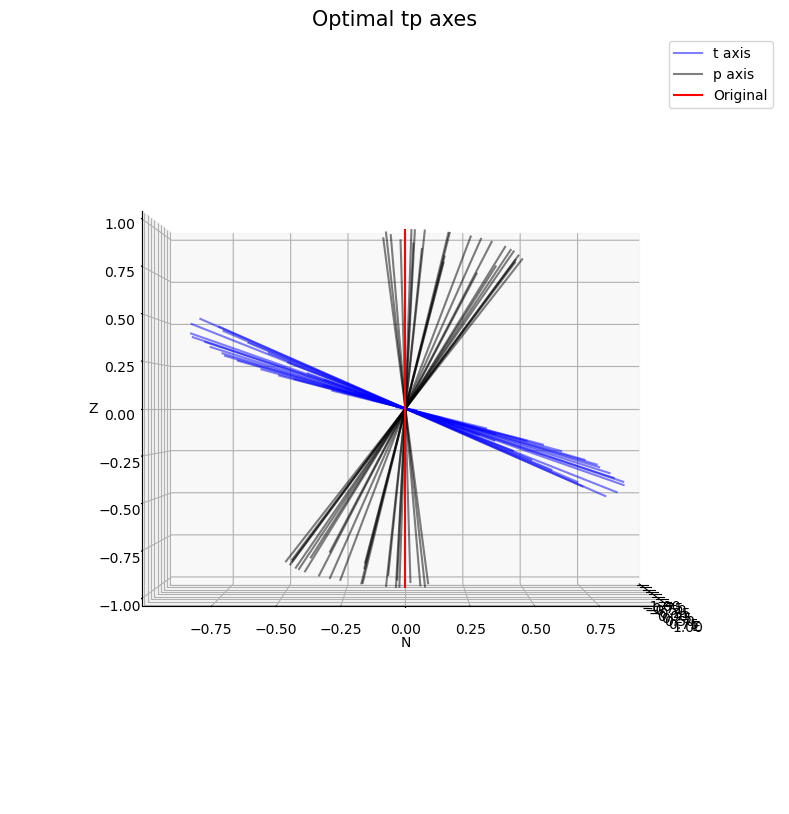

In [12]:
# optimal plot - tp space, collapse to central
importlib.reload(plots)
plots.tp_axes(radiation_model, azim=0, elev=0, half=False)

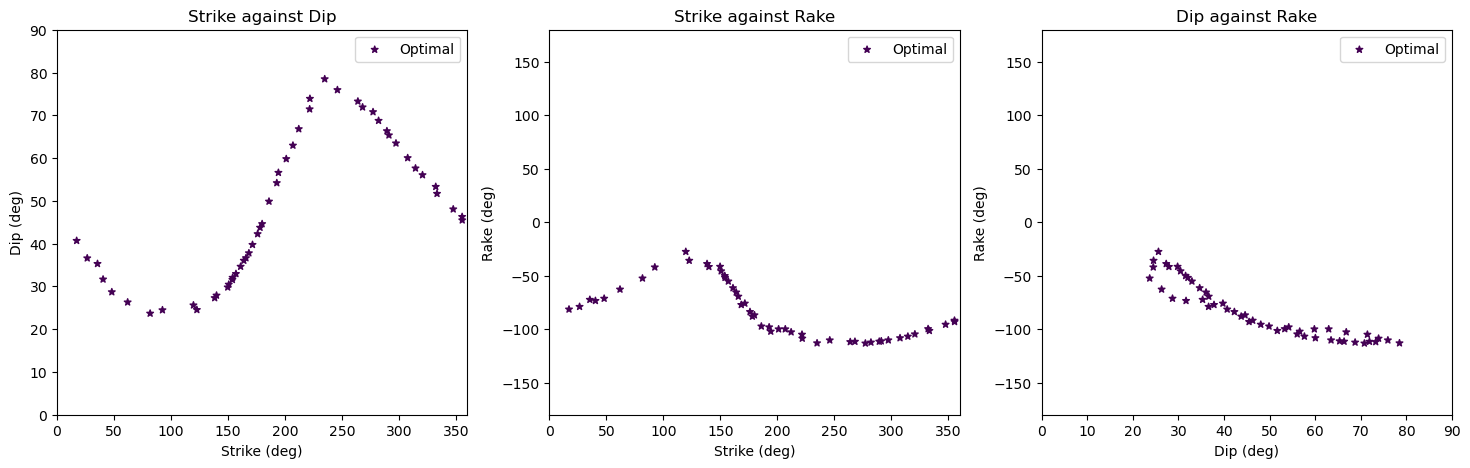

In [13]:
# iterate plot - sdr space
importlib.reload(plots)
plots.iterates_2D(radiation_model, s=25, optimal=True, index=2, cmap='viridis',
                  uncertainty=False)

In [26]:
# # amplitude plot
# importlib.reload(plots)
# radiation_model.reset_grid_amplitudes()
# radiation_model.set_grid_amplitudes(7, random=False, fix_params=False)
# plots.amplitudes(radiation_model, azim=0, elev=-0, s=50, alpha=0.5,
#                  iterates=False, grid=False, cross_section=[0,0,0],
#                  eps_factor=2e-2, optimal=True, observed=True, cmap='viridis')

In [27]:
############################
# NEXT STEP

# resolve the ability of the method to resolve mechanisms
# effect of uncertainties (is the broader family still constrained?)
# is it better to: grid search vs gradient descent, sdr vs moment tensor
# how does the solution depend on the misfit function used? cossim vs ratios

# tests to verify what the method can accomplish
############################

In [28]:
# # amplitude plot
# importlib.reload(plots)
# radiation_model.reset_grid_amplitudes()
# radiation_model.set_grid_amplitudes(3, random=False, fix_params=True)
# plots.amplitudes(radiation_model, azim=0, elev=-0, s=50, alpha=0.5,
#                  iterates=True, grid=True, cross_section=[3,3,3],
#                  eps_factor=2e-2, optimal=True, observed=True, cmap='viridis')

Seed = 101


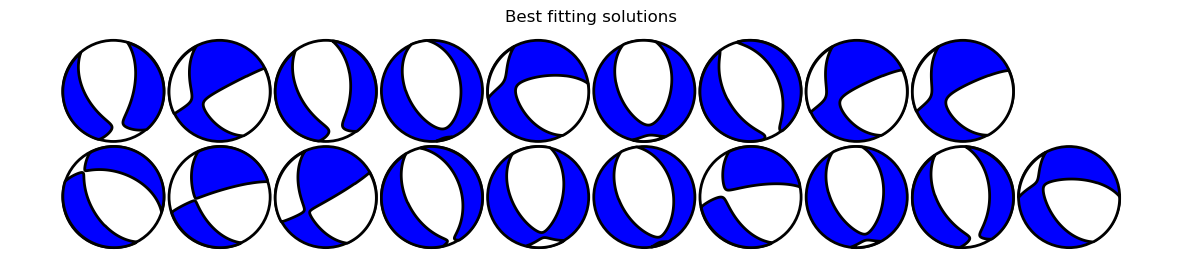

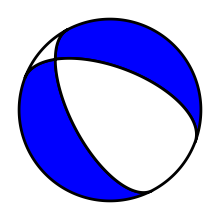

In [29]:
# beachball plots - NOT RELIABLE, PLOT FROM MT!!!

# BUG: Fix the moment tensor plots to match the beachball we see
# BUG: Just do it directly for the one MT I have in front of me

importlib.reload(plots)
max_plot = max(num_starts, 100)
print(f'Seed = {seed}')
plots.beachballs(radiation_model, central=False, order_by='tensor', max_plot=max_plot,
                 width=10, figsize=(15,10))
beachball

In [ ]:
opt_covs = radiation_model.get_optimal_covariances()
for i, cov in enumerate(opt_covs):
    print(f'Optimal covariance matrix for optimal iterate {i}:')
    print(cov)

Optimal covariance matrix for optimal iterate 0:
[[ 0.2383 -0.3307  0.6623]
 [-0.3307  0.8221 -1.4775]
 [ 0.6623 -1.4775  3.2829]]
Optimal covariance matrix for optimal iterate 1:
[[ 9.1912 -0.844   9.8095]
 [-0.844   0.1397 -0.9386]
 [ 9.8095 -0.9386 10.6553]]
Optimal covariance matrix for optimal iterate 2:
[[ 2.6042 -0.7154  3.1279]
 [-0.7154  0.2711 -0.9314]
 [ 3.1279 -0.9314  4.2897]]
Optimal covariance matrix for optimal iterate 3:
[[ 1.9119 -0.6119  2.4703]
 [-0.6119  0.2792 -0.8827]
 [ 2.4703 -0.8827  3.9583]]
Optimal covariance matrix for optimal iterate 4:
[[ 2.2046 -1.827  10.152 ]
 [-1.827   1.6001 -8.7243]
 [10.152  -8.7243 49.5947]]
Optimal covariance matrix for optimal iterate 5:
[[  1.4592   4.4931  -3.3053]
 [  4.4931  14.5737 -10.6662]
 [ -3.3053 -10.6662   7.9338]]
Optimal covariance matrix for optimal iterate 6:
[[ 0.9027 -0.3256  1.2939]
 [-0.3256  0.1726 -0.5377]
 [ 1.2939 -0.5377  2.5108]]
Optimal covariance matrix for optimal iterate 7:
[[ 0.3002 -0.3455  0.9503

In [30]:
# collect scale factors for each optimal iterate
# use scale factors together with jacobians to estimate input covariance
# combine all these onto a single plot

# so I'll go to model.py and add some methods
# method 1: get_optimal_scale_factors()
# method 2: get_input_covariances()
# method 3: edit 2d_iterates plot to show covariance ellipses
# (or covariance regions projected onto different 2d planes)

In [31]:
# after that: Paula's data. everything is ready at this point

# SIDE QUEST:
# remove laplacian stuff from the codebase

In [32]:
import matplotlib.pyplot as plt
hidden = radiation_model.get_hidden_optimal_iterates()
tensors = [fn.hidden2mt(params) for params in hidden]
lamb0, lamb1, lamb2 = [], [], []
for tensor in tensors:
    evals, evecs = np.linalg.eig(tensor)
    idx = evals.argsort()[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    lamb0.append(evals[0])
    lamb1.append(evals[1])
    lamb2.append(evals[2])


In [33]:
print(f'Max lamb0: {max(lamb0): .4f}, Min lamb0: {min(lamb0): .4f}, Avg lamb0: {np.mean(lamb0): .4f}')
print(f'Max lamb1: {max(lamb1): .4f}, Min lamb1: {min(lamb1): .4f}, Avg lamb1: {np.mean(lamb1): .4f}')
print(f'Max lamb2: {max(lamb2): .4f}, Min lamb2: {min(lamb2): .4f}, Avg lamb2: {np.mean(lamb2): .4f}')

Max lamb0:  1.3994, Min lamb0:  0.8075, Avg lamb0:  1.1154
Max lamb1:  0.0475, Min lamb1: -0.0414, Avg lamb1:  0.0083
Max lamb2: -0.8462, Min lamb2: -1.3935, Avg lamb2: -1.1237


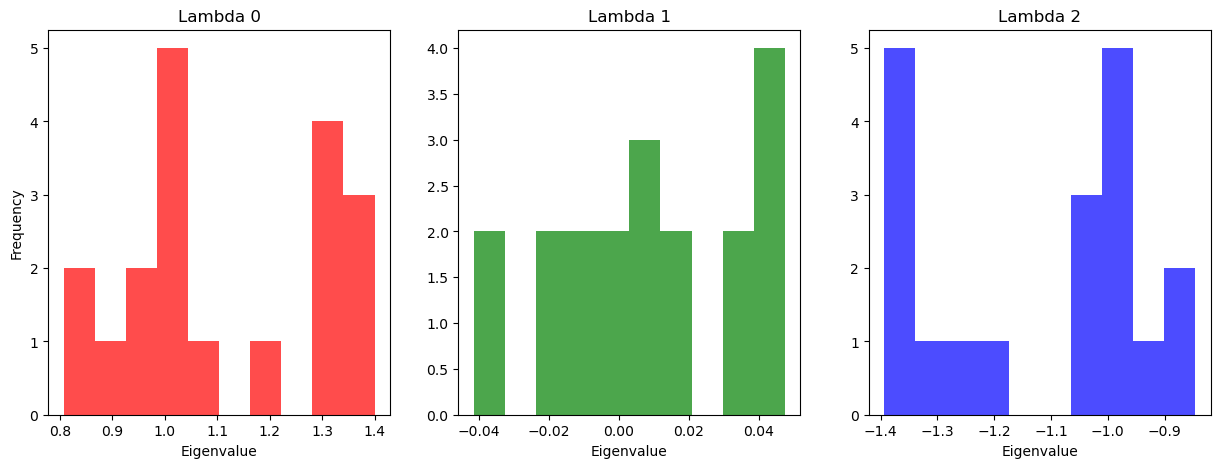

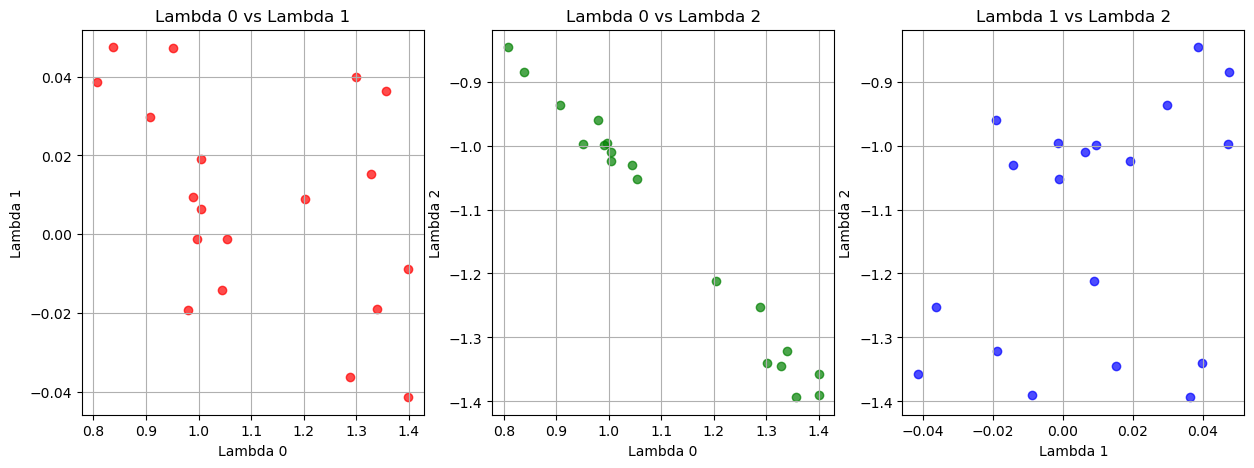

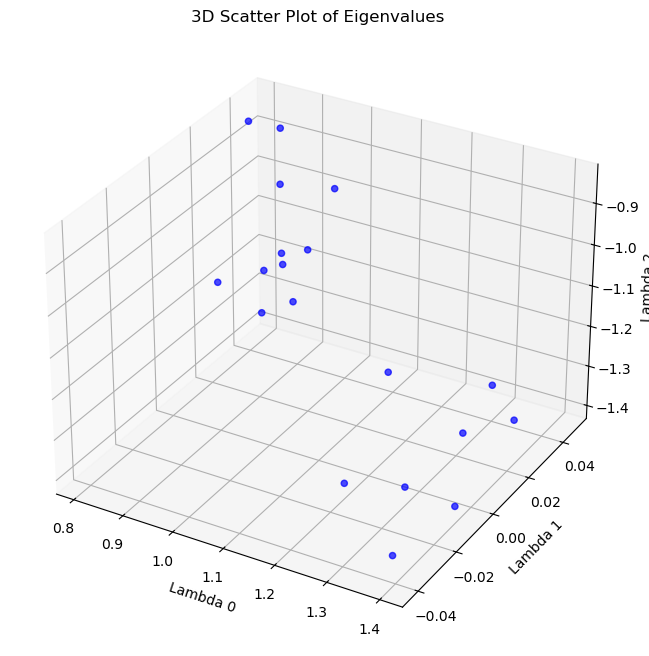

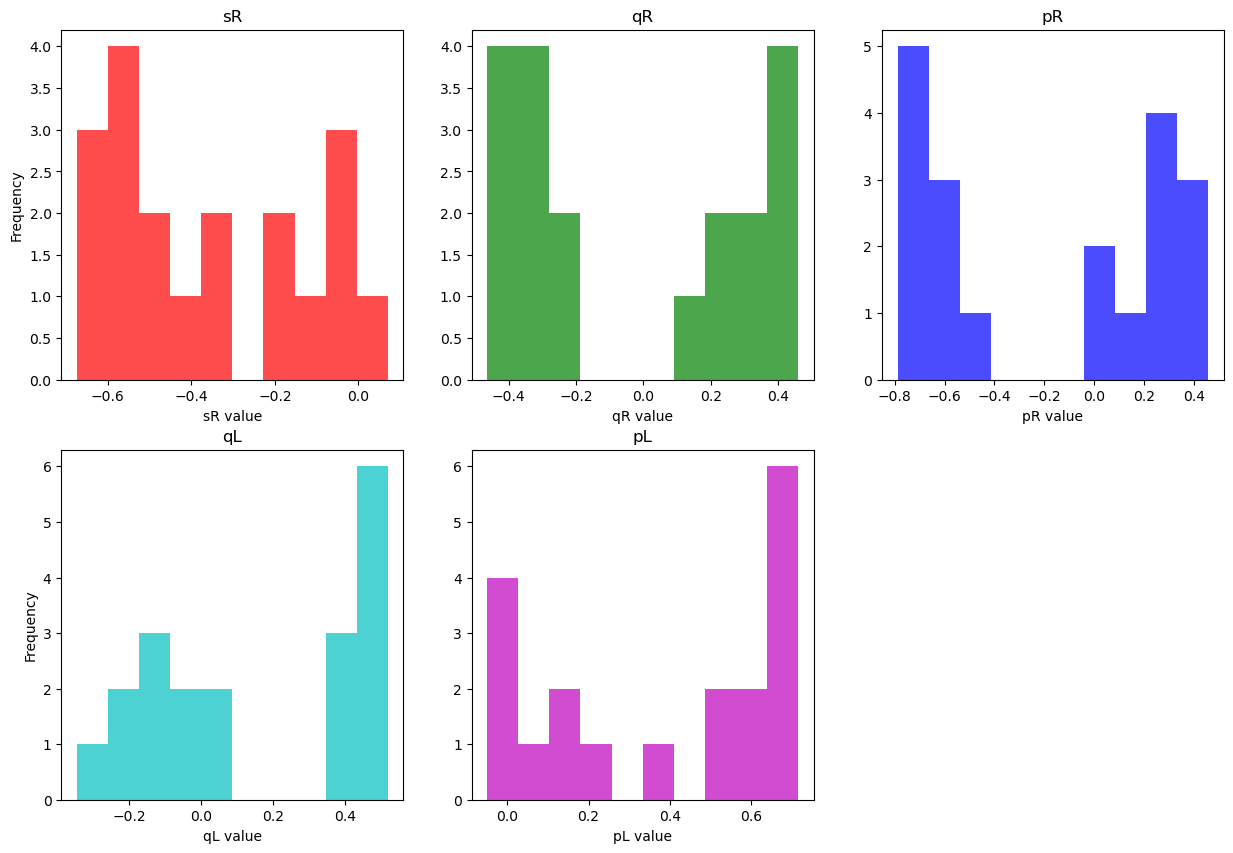

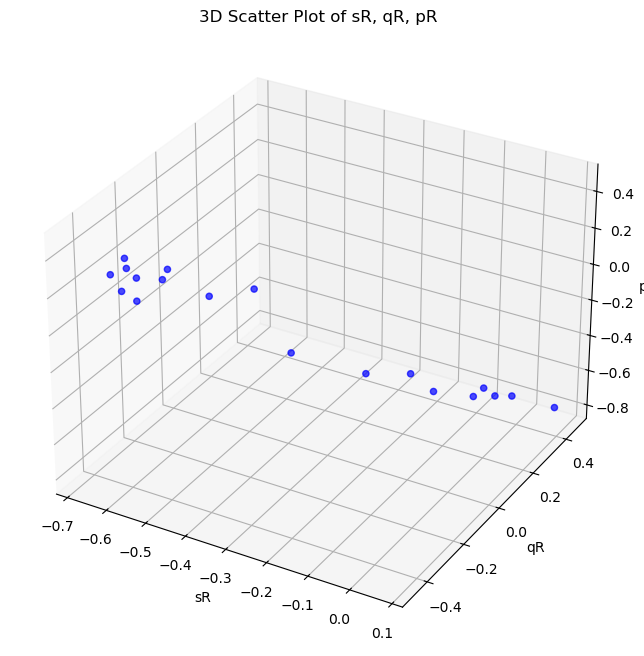

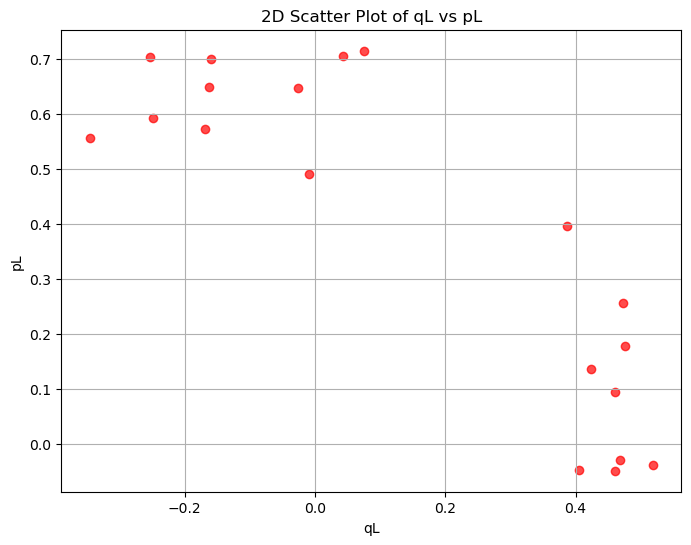

In [34]:

# make subplots of histograms for each eigenvalue
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(lamb0, bins=10, color='r', alpha=0.7)
axs[0].set_title('Lambda 0')
axs[0].set_xlabel('Eigenvalue')
axs[0].set_ylabel('Frequency')
axs[1].hist(lamb1, bins=10, color='g', alpha=0.7)
axs[1].set_title('Lambda 1')
axs[1].set_xlabel('Eigenvalue')
axs[2].hist(lamb2, bins=10, color='b', alpha=0.7)
axs[2].set_title('Lambda 2')
axs[2].set_xlabel('Eigenvalue')
plt.show()

# 2d scatter plots of lamb0 vs lamb1, lamb0 vs lamb2, lamb1 vs lamb2
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(lamb0, lamb1, c='r', alpha=0.7)
plt.xlabel('Lambda 0')
plt.ylabel('Lambda 1')
plt.title('Lambda 0 vs Lambda 1')
plt.grid(True)
plt.subplot(1, 3, 2)
plt.scatter(lamb0, lamb2, c='g', alpha=0.7)
plt.xlabel('Lambda 0')
plt.ylabel('Lambda 2')
plt.title('Lambda 0 vs Lambda 2')
plt.grid(True)
plt.subplot(1, 3, 3)
plt.scatter(lamb1, lamb2, c='b', alpha=0.7)
plt.xlabel('Lambda 1')
plt.ylabel('Lambda 2')
plt.title('Lambda 1 vs Lambda 2')
plt.grid(True)
plt.show()

# 3d scatter plot of lamb0, lamb1, lamb2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(lamb0, lamb1, lamb2, c='b', alpha=0.7)
ax.set_xlabel('Lambda 0')
ax.set_ylabel('Lambda 1')
ax.set_zlabel('Lambda 2')
ax.set_title('3D Scatter Plot of Eigenvalues')
plt.show()

sRs = [params[0] for params in hidden]
qRs = [params[1] for params in hidden]
pRs = [params[2] for params in hidden]
qLs = [params[3] for params in hidden]
pLs = [params[4] for params in hidden]

# make subplots of histograms for each parameter
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].hist(sRs, bins=10, color='r', alpha=0.7)
axs[0, 0].set_title('sR')
axs[0, 0].set_xlabel('sR value')
axs[0, 0].set_ylabel('Frequency')
axs[0, 1].hist(qRs, bins=10, color='g', alpha=0.7)
axs[0, 1].set_title('qR')
axs[0, 1].set_xlabel('qR value')
axs[0, 2].hist(pRs, bins=10, color='b', alpha=0.7)
axs[0, 2].set_title('pR')
axs[0, 2].set_xlabel('pR value')
axs[1, 0].hist(qLs, bins=10, color='c', alpha=0.7)
axs[1, 0].set_title('qL')
axs[1, 0].set_xlabel('qL value')
axs[1, 0].set_ylabel('Frequency')
axs[1, 1].hist(pLs, bins=10, color='m', alpha=0.7)
axs[1, 1].set_title('pL')
axs[1, 1].set_xlabel('pL value')
axs[1, 2].axis('off')  # hide the empty subplot
plt.show()

# 3d plot of sR, qR, pR
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(sRs, qRs, pRs, c='b', alpha=0.7)
ax.set_xlabel('sR')
ax.set_ylabel('qR')
ax.set_zlabel('pR')
ax.set_title('3D Scatter Plot of sR, qR, pR')
plt.show()

# 2d plot of qL, pL
plt.figure(figsize=(8, 6))
plt.scatter(qLs, pLs, c='r', alpha=0.7)
plt.xlabel('qL')
plt.ylabel('pL')
plt.title('2D Scatter Plot of qL vs pL')
plt.grid(True)
plt.show()